#### Problem Description:

The problem is to predict number of monthly armed robberies in Boston,USA



#### Asumptions:

     - Dataset is not current
     - We cannot easily collect updated data to valudare the model
     - We pretend that it is  Oct 1974 and withold the last one year od data from analysis and model selection
     

In [43]:
# importing required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load data set
series = pd.read_csv('monthly-robberies.csv',header=0,index_col=0,parse_dates=True,squeeze=True) 

In [3]:
#splitting into a traning and validation dataset
split_point = len(series)-12

dataset,validation = series[0:split_point],series[split_point:]
print('Dataset %d, Validation %d'%(len(dataset),len(validation)))
dataset.to_csv('dataset.csv',header=False)
validation.to_csv('validation.csv',header=False)



Dataset 106, Validation 12


###### Contents of the file

- dataset.csv : Obervation from Jan 1966 to Oct 1974 (106 Observations)
- validation.csv : Observation from Nov 1974 to Oct 1975 (12 observation)


Test Strategy:
    - Candidate model will be evaluated using walk forward validation. This is beacuse a rolling forecast type model is required from problem definition. The model works as follows
    
    1) 50% of the dataset will be held back to train the model
    2) Remaining 50% of the dataset will be iterated and test the model
    3) For each step in the test dataset:
        a) A model will be trained
        b) A one-step prediction is made and the prediction is stored for later evaluation
        c) The actual observation from the test dataset will be added to the training dataset for the next  
            iteration
    4) Predictions made during the iteration of the test dataset will be evaluated and an RMSE score is reported
        
        

In [10]:
#prepare the data
x = series.values
x = x.astype('float32')
train_size = int(len(x)*0.5)
train,test = x[0:train_size],x[train_size:]

#### Persistence

- First step getting bogged down in data analysis and modelling is to establish a baseline of performance. This
  will provide both a template for evaluation models using the proposed test harness and a performance measure by 
  which all more elaborate predictive models can be compared.

- This baseline prediction for time series forcasting is called naive forecasting

In [37]:
#load data
series = pd.read_csv('dataset.csv',index_col=0,parse_dates=True)
#prepare the data
x = series.values
x = x.astype('float32')
train_size = int(len(x)*0.5)
train,test = x[0:train_size],x[train_size:]

In [38]:
# walk forward validation
history = [x for x in train]
prediction = []
for t in range(len(test)):
    yhat = history[-1]
    history.append(test[t])
    prediction.append(yhat)
    print("Predicted = %.3f,Expected = %.3f"%(yhat,test[t]))

#report performance
rmse = sqrt(mean_squared_error(test,prediction))
print('RMSE: %.3f'%rmse)

Predicted = 98.000,Expected = 125.000
Predicted = 125.000,Expected = 155.000
Predicted = 155.000,Expected = 190.000
Predicted = 190.000,Expected = 236.000
Predicted = 236.000,Expected = 189.000
Predicted = 189.000,Expected = 174.000
Predicted = 174.000,Expected = 178.000
Predicted = 178.000,Expected = 136.000
Predicted = 136.000,Expected = 161.000
Predicted = 161.000,Expected = 171.000
Predicted = 171.000,Expected = 149.000
Predicted = 149.000,Expected = 184.000
Predicted = 184.000,Expected = 155.000
Predicted = 155.000,Expected = 276.000
Predicted = 276.000,Expected = 224.000
Predicted = 224.000,Expected = 213.000
Predicted = 213.000,Expected = 279.000
Predicted = 279.000,Expected = 268.000
Predicted = 268.000,Expected = 287.000
Predicted = 287.000,Expected = 238.000
Predicted = 238.000,Expected = 213.000
Predicted = 213.000,Expected = 257.000
Predicted = 257.000,Expected = 293.000
Predicted = 293.000,Expected = 212.000
Predicted = 212.000,Expected = 246.000
Predicted = 246.000,Expect

Note: We can see that persistance model achieved an RMS of 51.844. This mean on avergae, the model was wrong by 51 robberies

#### Data Analysis

In [40]:
# Sumamry statistics

series.describe()

,41
count,105.000000
mean,174.361905
std,112.015806
min,29.000000
25%,77.000000
50%,149.000000
75%,273.000000
max,487.000000


Obervations:

 - Mean is about 174 , which we might consider our level in series
 - Standard deviation is relatively large 112 robberies
 - Percentiles along with stand deviation suggest a large spread in data
 - Large spread in this series will likely make highly accurate prediction difficult if it casused by random fluctuation

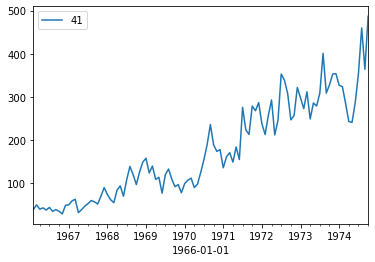

In [41]:
# Line plot

series.plot()
plt.show()

Observations:

    - There is increasing trend of robberies over time
    - Outlier does not seems to appear
    - There is lot of fluctuation from year to year
    - There are more fluctuation afrer 1971
    - Trend means certainly the data is non-stationary and apparent in fluctuation may also contribute

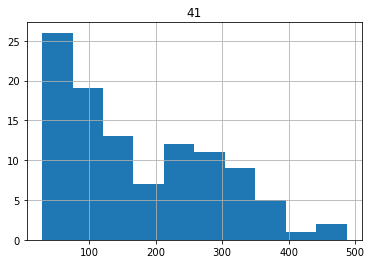

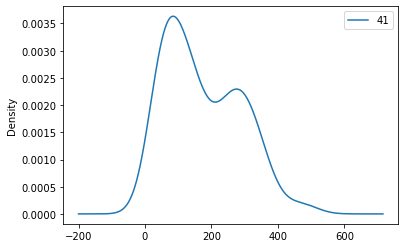

In [55]:
#Density plot
series.hist()
plt.show()
series.plot(kind='kde')
plt.show()

Observations :

    - Distribution is not Gaussain
    - Distribution may be left shifted and may be exponential or a double Gaussian

C:\Users\kokal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

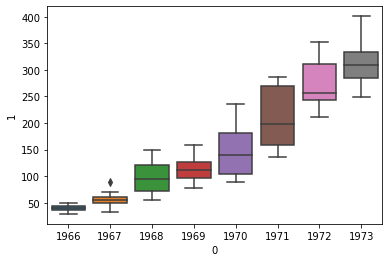

In [40]:
#box and whister plot
series = pd.read_csv('dataset.csv',index_col=0,header=None,parse_dates=True,squeeze=True)
series = series['1966':'1973']
sns.boxplot(series.index.year,series)


#### Observations

    - Median Value for each year(red line) shows a trend that may not be linear
    - Spread or middle 50% of the data diffrer but not consistenly over time
    - THe earlier years ,perhapds the first 2, are quite diffrent from the rest of dataset


In [38]:
#Stationarity Check

def adfuller_test(x):
    from statsmodels.tsa.stattools import adfuller
    
    result =adfuller(x)

    print('ADF Statistics: %f'%result[0])
    print('p-value: %f'%result[1])
    print('Critical Values')
    for key,value in result[4].items():
        print('\t%s: %.3f'%(key,value))
    
    P_value = result[1]
    adf_statistics = result[0]
    critical_value = result[4]['5%']

    # test at 95% confidence

    if P_value<0.005 and adf_statistics < critical_value:
        print("Reject Null Hypothesis")
        print("Times Series does not have a unit root,means it is a stationary series")

    else:
        print("Fail to Reject Null Hypothesis")
        print("Times Series has a unit root,means it is a non-stationary series")

In [59]:
series = pd.read_csv('dataset.csv',index_col=0,header=0,parse_dates=True)
adfuller_test(series)

ADF Statistics: 0.783043
p-value: 0.991357
Critical Values
	1%: -3.504
	5%: -2.894
	10%: -2.584
Fail to Reject Null Hypothesis
Times Series has a unit root,means it is a non-stationary series


Observation:

    -  Dataset is non-stationary and it is confirmed using ADF test.
    -  Must use Diffrence to bring it to staitonary data set

#### ARIMA Models

- For this project we will ARIMA models to forecast into the future

In [37]:
# Manually configured ARIMA

""" Analysis of time series assumes that we are wokring with a stationary time series.
    But as per ADF statistic test we can significantly conculde that series is non stationary.
    We can make it stationary by taking diffrencing and test to confirm if the result is stationary """

# fuction for creating diffrenced time series
def diffrence(dataset):
    diff= []
    for i in range(1,len(dataset)):
        value = dataset[i]-dataset[i-1]
        diff.append(value)
    
    return (pd.Series(diff))

#load data
series = pd.read_csv('dataset.csv',index_col=0,header=None,squeeze=True,parse_dates=True)
x = series.values

#diffrence data
stationary = diffrence(x)
stationary.indexex = series.index[1:]


In [39]:
#check for stationarity

adfuller_test(stationary)


ADF Statistics: -3.980946
p-value: 0.001514
Critical Values
	1%: -3.503
	5%: -2.893
	10%: -2.584
Reject Null Hypothesis
Times Series does not have a unit root,means it is a stationary series


#### Observations:
    -  TIme series suggest that atleast one level of diffrencing is required.
    -  Hence our d parameter will be atleast value of 1.

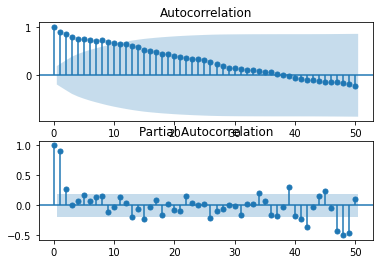

In [44]:
# determining p and q parametes using ACF and PACF plots

#load dataset
series = pd.read_csv('dataset.csv',header=None,index_col=0,parse_dates=True,squeeze=True)

plt.figure()
plt.subplot(211)
plot_acf(series,lags=50,ax = plt.gca())
plt.subplot(212)
plot_pacf(series,lags=50,ax = plt.gca())
plt.show()

#### Obervations:
    - ACF shows significant lag for 10-11 months
    - PACF shows significant lag for perhaps 2 months
    - Both PACF and ACF show a drop off at some point,perhaps suggesting a mix of AR and MA
    - A good starting point for P and q values are (0 to 2) and q - (0 to 11)

In [ ]:
#Experimentation shows that model does not appear to be stable with non zero AR and we simplied model to ARIMA(0,1,2)

In [48]:
# evaluation manually configured ARIMA model

#laod data
series = pd.read_csv('dataset.csv',header=None,index_col=0,parse_dates=True,squeeze=True)

#prepare data
x = series.values
x = x.astype('float32')
train_size = int(len(x)*0.5)
train,test = x[0:train_size],x[train_size:]

#walk forward validation

history= [x for x in train]
predictions = []

for i in range(len(test)):
    #Predict
    model = ARIMA(history,order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    #observation
    obs=test[i]
    history.append(obs)
    print('Prediction = %.3f, Expected = %.3f'%(yhat,obs))

#Report performance
rmse = sqrt(mean_squared_error(test,predictions))
print('RMSE: %.3f'%rmse)
    




Prediction = 102.710, Expected = 125.000
Prediction = 118.868, Expected = 155.000
Prediction = 141.099, Expected = 190.000
Prediction = 176.593, Expected = 236.000
Prediction = 233.418, Expected = 189.000
Prediction = 186.905, Expected = 174.000
Prediction = 184.846, Expected = 178.000
Prediction = 183.763, Expected = 136.000
Prediction = 146.180, Expected = 161.000
Prediction = 171.279, Expected = 171.000
Prediction = 170.196, Expected = 149.000
Prediction = 154.425, Expected = 184.000
Prediction = 185.707, Expected = 155.000
Prediction = 157.284, Expected = 276.000
Prediction = 245.280, Expected = 224.000
Prediction = 222.242, Expected = 213.000
Prediction = 219.698, Expected = 279.000
Prediction = 261.506, Expected = 268.000
Prediction = 264.287, Expected = 287.000
Prediction = 282.759, Expected = 238.000
Prediction = 255.843, Expected = 213.000
Prediction = 235.189, Expected = 257.000
Prediction = 257.622, Expected = 293.000
Prediction = 280.345, Expected = 212.000
Prediction = 235

### Grid search ARIMA Hyperparamets

There could be ARIMA configuarations that are unstable with dataset, but theere may other hyparameters that result in well performed model.

WE will search for combinaiton for p,d,q values that result in best performance

P: 0 to 3
d: 0: to 3
q: 0 to 12


In [22]:
#grid seach ARIMA parameters for time series


#evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(x,arima_order):
    
    # Prepare Training data
    x  = x.astype('float32')
    train_size = int(len(x)*0.5)
    train,test = x[0:train_size],x[train_size:]
    history = [i for i in train]
    
    #make prediction
    prediction = list()
    for t in range(len(test)):
        model = ARIMA(history,order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        prediction.append(yhat)
        history.append(test[t])
    
    #Calculate RMSE
    rmse = sqrt(mean_squared_error(test,prediction))
    return rmse

#evaluate combinations of p,d,q values for ARIMA model

def evaluate_models(dataset,p_values,d_values,q_values):
    dataset = dataset.astype('float32')
    best_score,best_config = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset,order)
                    if rmse<best_score:
                        best_score,best_config = rmse, order
                    print("ARIMA %s RMSE = %.3f"%(order,rmse))
                except:
                    continue
    
    print("> Best ARIMA%s RMSE = %.3f"%(best_config,best_score))
    

#load dataset
series = pd.read_csv('dataset.csv',header=None,index_col=0,parse_dates=True,squeeze=True)





In [23]:
#evaluate parameters
p_values = range(0,4)
d_values = range(0,4)
q_values = range(0,4)

evaluate_models(series.values,p_values,d_values,q_values)
    

ARIMA (0, 0, 0) RMSE = 154.962
ARIMA (0, 0, 1) RMSE = 99.360
ARIMA (0, 0, 2) RMSE = 89.842
ARIMA (0, 0, 3) RMSE = 72.274
ARIMA (0, 1, 0) RMSE = 51.827
ARIMA (0, 1, 1) RMSE = 50.417
ARIMA (0, 1, 2) RMSE = 49.821
ARIMA (0, 1, 3) RMSE = 51.003
ARIMA (0, 2, 0) RMSE = 80.804
ARIMA (0, 2, 1) RMSE = 52.456
ARIMA (0, 2, 2) RMSE = 51.154
ARIMA (0, 2, 3) RMSE = 50.934
ARIMA (1, 0, 0) RMSE = 53.243
ARIMA (1, 1, 0) RMSE = 50.582
ARIMA (1, 1, 1) RMSE = 49.069
ARIMA (1, 2, 0) RMSE = 68.672
ARIMA (2, 0, 0) RMSE = 52.032
ARIMA (2, 1, 0) RMSE = 50.761
ARIMA (2, 1, 1) RMSE = 50.407
ARIMA (2, 2, 0) RMSE = 61.384
ARIMA (2, 2, 1) RMSE = 51.388
ARIMA (3, 0, 0) RMSE = 52.235
ARIMA (3, 1, 0) RMSE = 51.901
ARIMA (3, 1, 1) RMSE = 50.295
ARIMA (3, 1, 2) RMSE = 51.058
ARIMA (3, 2, 0) RMSE = 60.411
ARIMA (3, 2, 1) RMSE = 52.830
> Best ARIMA(1, 1, 1) RMSE = 49.069


In [16]:
### we will use auto_arima to find optimized paramets

from pmdarima import auto_arima

ar = auto_arima(series,start_p=0,start_q=0,max_p=4,max_q=12,d=1)

In [17]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  106
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -523.847
Date:                Sun, 06 Mar 2022   AIC                           1055.694
Time:                        13:50:05   BIC                           1066.310
Sample:                             0   HQIC                          1059.996
                                - 106                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6247      0.493      3.294      0.001       0.658       2.592
ar.L1          0.5265      0.111      4.745      0.000       0.309       0.744
ma.L1         -0.9386      0.054    -17.248      0.000      -1.045      -0.832
sigma2      1248.6231    147.698      8.454      0.000     959.140    1538.106
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                49.39
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):              10.09   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

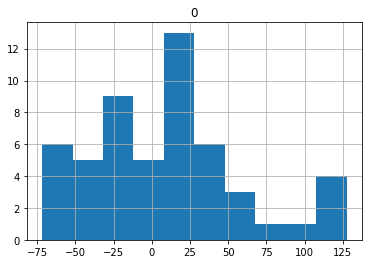

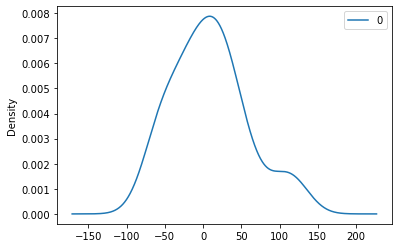

In [26]:
#lets fit the model with order(1,1,1)

#load data set
series = pd.read_csv('dataset.csv',header=None,index_col=0,parse_dates=True,squeeze=True)

#prepare data set
x = series.values
x=x.astype('float32')
train_size = int(len(x)*0.5)
train,test = x[0:train_size],x[train_size:]


#walk forward validation
history = [x for x in train]
prediction = []
for i in range(len(test)):
    #predict
    model = ARIMA(history,order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    prediction.append(yhat)
    #observation
    obs = test[i]
    history.append(obs)
    
# Review Residual errors

""" A good final check of a model is to review residual forecast errors. Ideally the distribution of residual error should be
gausian with a zero mean"""

#errors
residuals = [test[i]-prediction[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)

residuals.hist()
plt.show()

residuals.plot(kind='kde')
plt.show()


##### Observation:
Graph suggest Gaussian like distribution with a longer right tail. this perhaps suggest that predictions are biased and in this case a power based transformation of the raw data before modeliing might be helpful

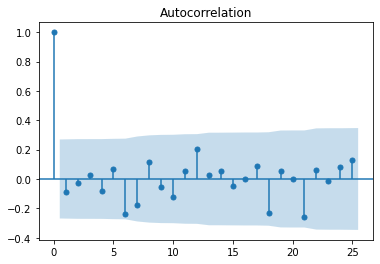

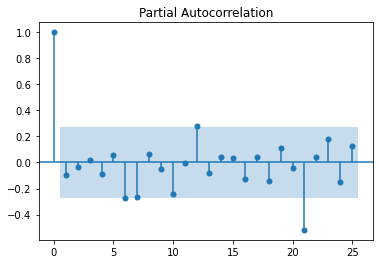

In [27]:
# ACF and PACF plots of forecasr residual errors
plot_acf(residuals,lags=25)
plt.show
plot_pacf(residuals,lags=25)
plt.show()

#### Observation:
The result suggest that little correlation is present in the residual of the time series

Lambda 0.26006033924618177


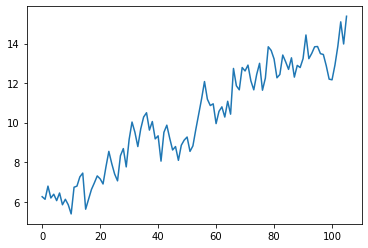

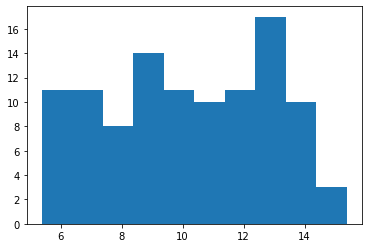

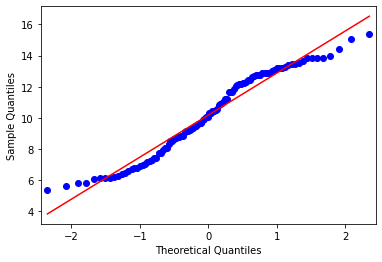

In [29]:
# Box- Cox Transformed Dataset

#Lets perform log tranform of the data and generate some plots to review

from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot

#load data set
series = pd.read_csv('dataset.csv',header=None,index_col=0,parse_dates=True,squeeze=True)
x= series.values

transformed,lam = boxcox(x)
print('Lambda',lam)

#line plot
plt.plot(transformed)
plt.show()

#histogram
plt.hist(transformed)
plt.show()

#qq plot
qqplot(transformed,line='r')
plt.show()


##### observation:

    - Large observation have been removed from the line plot
    - Histogram shows flatter and more unfirom distribution of values
    - QQ plot is reasonable and still not a perfect Gaussian distribution
 

In [30]:
#inverse box cox transformation
from math import log, exp
def boxcox_inverse(value,lam):
    if lam == 0:
        return(value)
    return exp(log(lam* value + 1)/lam)

In [37]:
# lets re-evaluate the ARIMA (1,1,1) model with box cox tranform

#load data set
series = pd.read_csv('dataset.csv',header=None,index_col=0,parse_dates=True,squeeze=True)

#prepare data set
x = series.values
x=x.astype('float32')
train_size = int(len(x)*0.5)
train,test = x[0:train_size],x[train_size:]


#walk forward validation
history = [ x for x in train]
predictions = []

for i in range(len(test)):
    #tranform
    transformed,lam = boxcox(history)
    if lam <-5:
        transformed,lam = history,1
    #predict
    model = ARIMA(transformed,order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    #inverted boxcox
    yhat = boxcox_inverse(yhat,lam)
    predictions.append(yhat)
    #observation
    obs = test[i]
    history.append(obs)
    print("Prediction %.3f Expected %.3f"%(yhat,obs))

#report performance
rmse = sqrt(mean_squared_error(test,predictions))
print('RMSE %.3f'%rmse)

Prediction 102.716 Expected 125.000
Prediction 119.124 Expected 155.000
Prediction 152.383 Expected 190.000
Prediction 178.041 Expected 236.000
Prediction 212.054 Expected 189.000
Prediction 185.154 Expected 174.000
Prediction 176.503 Expected 178.000
Prediction 180.499 Expected 136.000
Prediction 151.629 Expected 161.000
Prediction 169.479 Expected 171.000
Prediction 177.400 Expected 149.000
Prediction 162.505 Expected 184.000
Prediction 187.327 Expected 155.000
Prediction 168.373 Expected 276.000
Prediction 246.940 Expected 224.000
Prediction 220.389 Expected 213.000
Prediction 215.368 Expected 279.000
Prediction 258.197 Expected 268.000
Prediction 256.546 Expected 287.000
Prediction 272.017 Expected 238.000
Prediction 245.039 Expected 213.000
Prediction 230.033 Expected 257.000
Prediction 259.574 Expected 293.000
Prediction 284.914 Expected 212.000
Prediction 236.520 Expected 246.000
Prediction 258.950 Expected 353.000
Prediction 325.512 Expected 339.000
Prediction 324.017 Expected 

##### We will use this model with box-cox transform as final model

In [39]:
#finalize model ans save to file to work around

#monkey patch around bug in ARIMA class

def __getnewargs__(self):
    return((self.endog),(self.k_lags,self.k_diff,self.k_ma))

ARIMA.__getnewargs__=__getnewargs__


In [40]:
#Load data

series = pd.read_csv('dataset.csv',header=None,index_col=0,parse_dates=True,squeeze=True)

#prepare dataset
x = series.values
x=x.astype('float32')

#tranform data
transformed,lam = boxcox(x)

#fit model
model = ARIMA(transformed,order=(1,1,1))
model_fit = model.fit(disp=0)

#save model
model_fit.save('model.pkl')
np.save('model_lambda.npy',[lam])


###### model.pk : This ARIMA resultobject and included the coefficients and all other internal data returned when fitting model

##### model_lambda : This is the lambda values stores as numpy array


In [44]:
# Model Validation

#load the finalized model and make a prediction

model_fit = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')

yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat,lam)
print("Prediction",yhat)

Prediction 459.8003358240795


### Validate Model

There are two ways we might proceed

    -Load the model and use it to forecast the next 12 months. The forecast beyond the first one or two months 
      will quickly start to degrade in skill
      
    -Load the model and use it in rolling forecast manner,updating the transform and model for each time step. 
    
 Note: The second method is prefered as this model is used in practice as it would achieve best performance

In [63]:
# Load and prepare datasets

dataset = pd.read_csv('dataset.csv',header=None,index_col=0,parse_dates=True,squeeze=True)
x = dataset.values.astype('float32')
history = [i for i in x]

validation = pd.read_csv('validation.csv',header=None,index_col=0,parse_dates = True,squeeze=True)
y= validation.values.astype('float32')


In [64]:
#load model
model_fit = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')

In [65]:
#make a first prediction
prediction = []
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat,lam)
prediction.append(yhat)
print('Predicted = %.3f, Expected = %.3f' %(yhat,y[0]))

Predicted = 459.800, Expected = 452.000


Predicted = 452.039, Expected = 391.000
Predicted = 386.236, Expected = 500.000
Predicted = 475.822, Expected = 451.000
Predicted = 446.416, Expected = 375.000
Predicted = 413.004, Expected = 372.000
Predicted = 410.175, Expected = 302.000
Predicted = 355.960, Expected = 316.000
Predicted = 357.923, Expected = 398.000
Predicted = 400.394, Expected = 394.000
Predicted = 393.106, Expected = 431.000
Predicted = 423.613, Expected = 431.000
RMSE: 58.13973191986161


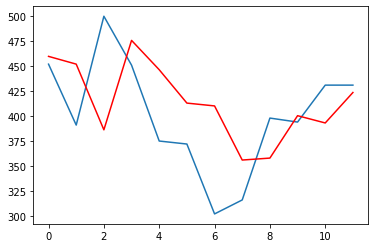

In [66]:
# rolling forecast
for i in range(1,len(y)):
    # transform
    tranform,lam = boxcox(history)
    if lam<-5:
        tranform,lam = history,1
    
    #predict
    model = ARIMA(tranform,order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    #invert box cox
    yhat = boxcox_inverse(yhat,lam)
    prediction.append(yhat)
    #observation
    obs=y[i]
    history.append(obs)
    print('Predicted = %.3f, Expected = %.3f' %(yhat,obs))

# report performance
rmse = sqrt(mean_squared_error(y,prediction))
print('RMSE:', rmse)

plt.plot(y)
plt.plot(prediction,color='r')
plt.show()